# Lab 2 Exploration: Color Images

In this notebook, we will learn how to use the racecar camera to identify objects based on their color and extract the center and area of these objects.

Throughout this notebook, **<font style="color:red">text in bold red</font>** indicates a change you must make to the following code block before running it.


## Table of Contents
1. [Getting Started](#GettingStarted)
2. [Taking Photos](#TakingPhotos)
3. [Color Formats](#ColorFormats)
4. [Masks](#Masks)
4. [Finding Contours](#FindingContours)
4. [Contour Center](#ContourCenter)
4. [Contour Area](#ContourArea)

<a id="GettingStarted"></a>
## 1. Getting Started

**<font style="color:red">If you are running the car in RacecarSim, set `isSimulation` to `True`</font>**. Leave `isSimulation` `False` if you are using a physical car.

In [1]:
# TODO: Update isSimulation if necessary
isSimulation = True

Next, we will import the necessary libraries for this notebook, including Python libraries (`cv`, `numpy`, etc.) and the Racecar library (`racecar_core`).

In [2]:
# Import Python libraries
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from nptyping import NDArray
from typing import Any, Tuple, List, Optional

# Import Racecar library
import sys
sys.path.append("../../library")
import racecar_core

The following functions will help us throughout this notebook.

In [3]:
def show_image(image: NDArray) -> None:
    """
    Displays a color image in the Jupyter Notebook.
    """
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
    plt.show()

    
def draw_contour(
    image: NDArray,
    contour: NDArray,
    color: Tuple[int, int, int] = (0, 255, 0)
) -> None:
    """
    Draws a contour on the provided image.

    Args:
        image: The image on which to draw the contour.
        contour: The contour to draw on the image.
        color: The color to draw the contour in BGR format.
    """
    cv.drawContours(image_copy, [contour], 0, color, 3)

    
def draw_circle(
    color_image: NDArray[(Any, Any, 3), np.uint8],
    center: Tuple[int, int],
    color: Tuple[int, int, int] = (0, 255, 255),
    radius: int = 6,
) -> None:
    """
    Draws a circle on the provided image.

    Args:
        color_image: The color image on which to draw the contour.
        center: The pixel (row, column) of the center of the image.
        color: The color to draw the circle in BGR format.
        radius: The radius of the circle in pixels.
    """
    # cv.circle expects the center in (column, row) format
    cv.circle(color_image, (center[1], center[0]), radius, color, -1)

    
def show_color_bgr(blue: int, green: int, red: int) -> None:
    """
    Displays a color specified in the BGR format.
    """
    rectangle = plt.Rectangle((0,0), 50, 50, fc=(red/255, green/255, blue/255))
    plt.gca().add_patch(rectangle)
    plt.show()

    
def show_color_hsv(hue: int, saturation: int, value: int) -> None:
    """
    Displays a color specified in the HSV format
    """
    # Convert from hsv to bgr
    hsv = np.array([[[hue, saturation, value]]], np.uint8)
    bgr = cv.cvtColor(hsv, cv.COLOR_HSV2BGR)
    
    show_color_bgr(bgr[0][0][0], bgr[0][0][1], bgr[0][0][2])

Finally, we will create a racecar object.  If this step fails, make sure that `isSimulation` has the correct value.

In [4]:
# Create Racecar
rc = racecar_core.create_racecar(isSimulation)

<a id="TakingPhotos"></a>
## 2. Taking Photos
In Jupyter Notebook, we can take a photo with the car's camera using `rc.camera.get_color_image_async()`.  Outside of Jupyter Notebook, we must use `rc.camera.get_color_image()` instead.

Let's see what the car is currently looking at.

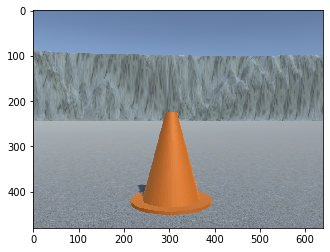

In [9]:
# Take and display a photo
image = rc.camera.get_color_image_async()
show_image(image)

Color images are stored as three dimensional numpy arrays:

* **0th dimension**: pixel rows, indexed from top to bottom.
* **1st dimension**: pixel columns, indexed from left to right.
* **2nd dimension**: pixel color values, ordered blue, green, red, each ranging from 0 (none of that color) to 255 (maximum amount of that color). 

Let's look at the color values of the middle pixel of our image.

blue: 48
green: 113
red: 202


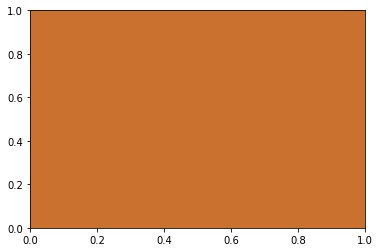

In [10]:
# Calculate center row and column
row = rc.camera.get_height() // 2
col = rc.camera.get_width() // 2

# Extract and print blue, green, and red values
blue = image[row][col][0]
green = image[row][col][1]
red = image[row][col][2]

print("blue:", blue)
print("green:", green)
print("red:", red)

# Display this color
show_color_bgr(blue, green, red)

**<span style="color:red">Update `row` and `col` in the following code block to show the pixel that is is 2/3 from the top, 1/4 from the right.</span>**

blue: 160
green: 156
red: 147


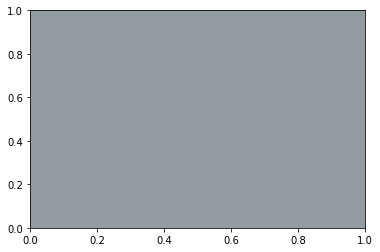

In [11]:
# TODO: Calculate the desired row and column 
row = (rc.camera.get_height() * 2) // 3
col = (rc.camera.get_width() * 3) // 4

# Extract and print blue, green, and red values
blue = image[row][col][0]
green = image[row][col][1]
red = image[row][col][2]

print("blue:", blue)
print("green:", green)
print("red:", red)

# Display this color
show_color_bgr(blue, green, red)

<a id="ColorFormats"></a>
## 3. Color Formats
By default, the images captured by the camera are stored in the blue-green-red (BGR) format.  However, when recognizing objects based on their color, it is far easier to use the hue-saturation-value (HSV) format, in which each channel corresponds to the following:

* **Hue** (0 to 180): The color as it appears on a color wheel, ordered as red-orange-yellow-green-blue-purple-red
* **Saturation** (0 to 255): The amount of white added to the color.  0 is pure white, and 255 is the pure color without any white added.
* **Value** (0 to 255): The amount of black added to the color.  0 is pure black, and 255 is the pure color without any black added.

While saturation and value vary with lighting, hue will remain mostly the same regardless of lighting.  By focusing on the hue of the object we are attempting to detect, we can find it even in different lighting environments.

We can use the following widgets to expiriment with different color values in the BGR and HSV formats.  **<font style="color:red">For both formats, find the values which produce the following colors: orange, pink, dark green, yellow, and gray.</font>**

In [12]:
# BGR color
widgets.interact(show_color_bgr,
                 blue=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 green=widgets.IntSlider(0, 0, 255, continuous_update=False),
                 red=widgets.IntSlider(0, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='blue', max=255), IntSlider(valu…

In [13]:
# HSV color
widgets.interact(show_color_hsv,
                 hue=widgets.IntSlider(0, 0, 180, continuous_update=False),
                 saturation=widgets.IntSlider(255, 0, 255, continuous_update=False),
                 value=widgets.IntSlider(255, 0, 255, continuous_update=False));

interactive(children=(IntSlider(value=0, continuous_update=False, description='hue', max=180), IntSlider(value…

<a id="Masks"></a>
## 4. Masks
Lets work on identifying an object in the car's field of view based on its color.  Specifically, we will isolate the portions of an image which fall within a certain color range by defining upper and lower HSV bounds.  We will use that to create a *mask* - a special type of image which is white in areas to include and black in areas not to include.

**<font style="color:red">Finish writting the function `get_mask` below, which takes an image and returns a mask of the areas between hsv_lower and hsv_upper.</font>**  You will likely wish to use the following OpenCV functions:

* [`cvtColor`](https://docs.opencv.org/4.2.0/d8/d01/group__imgproc__color__conversions.html#ga397ae87e1288a81d2363b61574eb8cab): Converts an image from one color format to another, such as from BGR to HSV.
* [`inRange`](https://docs.opencv.org/4.2.0/d2/de8/group__core__array.html#ga48af0ab51e36436c5d04340e036ce981): Creates a mask from an image based on a lower and upper color bound.

In [14]:
def get_mask(
    image: NDArray[(Any, Any, 3), np.uint8],
    hsv_lower: Tuple[int, int, int],
    hsv_upper: Tuple[int, int, int]
) -> NDArray[Any, Any]:
    """   
    Returns a mask containing all of the areas of image which were between hsv_lower and hsv_upper.
    
    Args:
        image: The image (stored in BGR) from which to create a mask.
        hsv_lower: The lower bound of HSV values to include in the mask.
        hsv_upper: The upper bound of HSV values to include in the mask.
    """
    # Convert hsv_lower and hsv_upper to numpy arrays so they can be used by OpenCV
    hsv_lower = np.array(hsv_lower)
    hsv_upper = np.array(hsv_upper)
    
    # TODO: Use the cv.cvtColor function to switch our BGR colors to HSV colors
    image = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    
    # TODO: Use the cv.inRange function to highlight areas in the correct range
    mask = cv.inRange(image, hsv_lower, hsv_upper)
    
    return mask

Let's use `get_mask` to isolate a cone in an image.  Place a cone in the car's line of sight and take a picture with the following block.

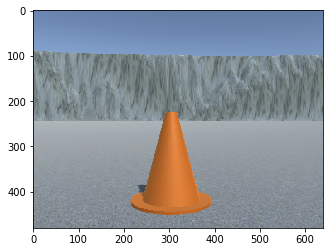

In [15]:
image = rc.camera.get_color_image_async()
show_image(image)

Next, we will use the `get_mask` function to create a mask containing just the cone.  At the moment, `hsv_lower` and `hsv_upper` include all possible HSV values, so the mask will contain the entire image.  **<font style="color:red">Tune the values of `hsv_lower` and `hsv_upper` until the mask only includes the cone.</font>**

**Hints:**

* Use the HSV color widget from [Color Formats](#ColorFormats) to visualize HSV colors.
* Copy the image into an image editing software (gimp, paint, etc.) and use the eyedrop tool to show the HSV values of the pixels in the cone.
* Saturation and value vary a lot with lighting, but hue will remain mostly constant for a given object. Try using a wide range for value and saturation but a tight range for hue.

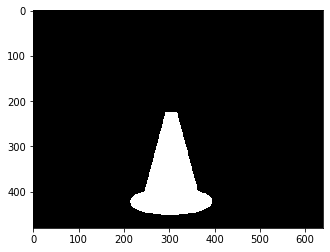

In [16]:
hsv_lower = (0, 50, 50)
hsv_upper = (20, 255, 255)

mask = get_mask(image, hsv_lower, hsv_upper)
show_image(mask)

We can use this mask as a filter for our original image to only keep portions that were between `hsv_lower` and `hsv_upper`.

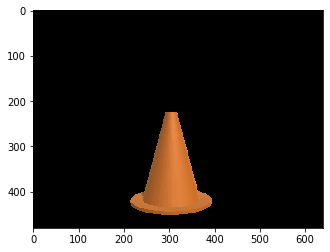

In [17]:
masked_image = cv.bitwise_and(image, image, mask=mask)
show_image(masked_image)

<a id="FindingContours"></a>
## 5. Finding Contours

Now that we have a mask, we can create outlines called _contours_ around each object in the mask.  We will use these outlines to identify the largest object and calculates its size and position.

First, we will use the OpenCV function [`findContours`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0) to create a list of contours around each distinct object in the mask.

In [18]:
def find_contours(mask: NDArray) -> List[NDArray]:
    """
    Returns a list of contours around all objects in a mask.
    """
    return cv.findContours(mask, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)[0]

`find_contours` will return a list containing multiple contours if there are multiple distinct objects which fall between `hsv_lower` and `hsv_upper`.  This might occur if there are multiple cones in the image or if there are other objects that have a similar color to the cone.

Let's write a helper function to identify the largest contour, which we will assume is the closest cone.  This helper function should also ignore contours below a minimum size (such as `30 pixels`), since anything below this size is likely too small to be our cone.

**<font style="color:red">Finish writing `get_largest_contour` so that it returns the largest contour larger than `min_area`, or `None` if no such contour exists.</font>**  You will likely wish to use the OpenCV [`contourArea`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function to find the number of pixels in a contour.

In [19]:
def get_largest_contour(contours: List[NDArray], min_area: int = 30) -> Optional[NDArray]:
    """
    Finds the largest contour with size greater than min_area.

    Args:
        contours: A list of contours found in an image.
        min_area: The smallest contour to consider (in number of pixels)

    Returns:
        The largest contour from the list, or None if no contour was larger than min_area.
    """
    if len(contours) == 0:
        # TODO: What should we return if the list of contours is empty?
        return None
    
    # TODO: Return the largest contour, but return None if no contour is larger than min_area
    greatest_contour = max(contours, key=cv.contourArea)
    if cv.contourArea(greatest_contour) < min_area:
        return None

    return greatest_contour

Let's try it out.  The following code block uses `find_contours` and `get_largest_contour` to find the largest contour and draw it on the image.  You should now see a green outline surrounding the closest cone in your image.

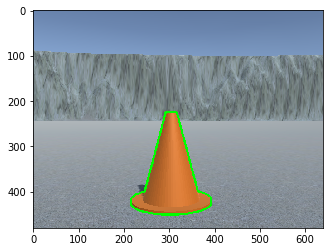

In [21]:
# Find the largest contour
contours = find_contours(mask)
largest_contour = get_largest_contour(contours)

# Draw it on the image
image_copy = np.copy(image)
draw_contour(image_copy, largest_contour)
show_image(image_copy)

<a id="ContourCenter"></a>
## 6. Contour Center

One advantage of contours is that we can use them to easily calculate the center of an object.  Specifically, we will use the contour's [_Moments_](https://en.wikipedia.org/wiki/Image_moment), which are weighted averages of the pixels in the contour.  We can calculate the moment $M_{ij}$ with the following formula:

```
def moment(i, j):
    sum = 0
    for pixel in contour:
        sum += pixel.x_position ** i + pixel.y_position ** j
    return sum
```

To calculate contour center, we will use the following moments:

* $M_{00}$: The number of pixels in the contour.
* $M_{10}$: The sum of how far to the right each pixel in the contour is.
* $M_{01}$: The sum of how far down each pixel in the contour is.

Using the [center of mass equation](https://en.wikipedia.org/wiki/Center_of_mass), $\frac{M['m10']}{M['m00']}$ gives us the average horizontal position (column) of the contour, and $\frac{M['m01']}{M['m00']}$ gives us the average vertical position (row).

In [22]:
def get_contour_center(contour: NDArray) -> Optional[Tuple[int, int]]:
    """
    Finds the center of a contour from an image.

    Args:
        contour: The contour of which to find the center.

    Returns:
        The (row, column) of the pixel at the center of the contour, or None if the contour is empty.
    """
    # Ask OpenCV to calculate the contour's moments
    M = cv.moments(contour)

    # Check that the contour is not empty
    if M["m00"] <= 0:
        return None

    # Compute the center of mass of the contour
    center_row = round(M["m01"] / M["m00"])
    center_column = round(M["m10"] / M["m00"])
    
    return (center_row, center_column)

To see if this worked, we will draw a dot at this calculated center point. You should now see a yellow dot at the center of the cone.

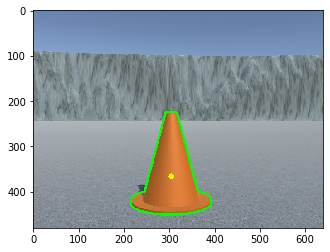

In [23]:
center = get_contour_center(largest_contour)

# Draw a circle at the contour center
draw_circle(image_copy, center)
show_image(image_copy)

<a id="ContourArea"></a>
## 7. Contour Area

When writing `get_largest_contour`, you likely used the OpenCV [`contourArea`](https://docs.opencv.org/4.2.0/d3/dc0/group__imgproc__shape.html#ga2c759ed9f497d4a618048a2f56dc97f1) function.  Contour area is also helpful for calculating how far an object is from the camera, since the closer an object is, the more pixels it will take up on the screen.

In this final section, we will measure the area of the cone at different distances from the car. Using previous examples from this notebook, **<font style="color:red">update the following code block to take a photo, find the largest contour, print the contour area, and display the image with the contour.</font>**

contour area: 802 pixels


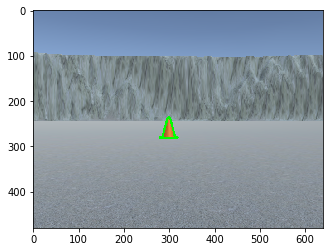

In [37]:
# TODO: Take a photo
image = rc.camera.get_color_image_async()

# TODO: Find the largest contour
mask = get_mask(image, hsv_lower, hsv_upper)
contours = find_contours(mask)
largest_contour = get_largest_contour(contours)

# TODO: Calculate and print the largest contour's area
if largest_contour is not None:
    area = round(cv.contourArea(largest_contour))
    print("contour area: {} pixels".format(area))
else:
    print("no contour found")

# TODO: Display the image with the contour drawn on top
image_copy = np.copy(image)
draw_contour(image_copy, largest_contour)

show_image(image_copy)

**<font style="color:red">Calculate the cone contour area when the cone is the following distances away from the car: 40 cm, 80 cm, 120 cm, 160 cm, 200 cm.  Update the entries in `data` with your results.</font>**

In [38]:
# Datapoints in the format (cone distance from car in cm, number of pixels in contour)
# TODO: Fill is contour area (currently 0)
data = [
    (40, 16249),
    (80, 4716),
    (120, 2187),
    (160, 1238),
    (200, 802),
]

Finally, let's plot this data to see the relationship between distance and cone area.  **How would you describe this relationship?**

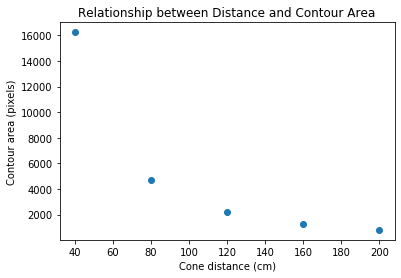

In [39]:
# Plot data in a scatter plot 
data_t = np.transpose(data)
plt.scatter(data_t[0], data_t[1])
plt.title("Relationship between Distance and Contour Area")
plt.xlabel("Cone distance (cm)")
plt.ylabel("Contour area (pixels)")
plt.show()

You are now ready to begin using the color camera to follow lines in `lab2a.py`. Good luck, and don't be afraid to ask questions!